In [1]:
import random, time, cv2
from matplotlib import pyplot as plt
from pydnet import darknet

random.seed(3)
input_file = './dog.jpg'

config_file = './yolov4-tiny.cfg'
data_file = './coco.data'
weights_file = './yolov4-tiny.weights'

thresh = 0.5

In [2]:
!wget -nc https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights

File ‘yolov4-tiny.weights’ already there; not retrieving.



In [3]:
network, class_names, class_colors = darknet.load_network(    
    config_file,
    data_file,
    weights_file,
)    
  
width = darknet.network_width(network)    
height = darknet.network_height(network)    
darknet_image = darknet.make_image(width, height, 3)    

image =  cv2.imread(input_file)
height_orig, width_orig, channels_orig = image.shape
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
image_resized = cv2.resize(image_rgb, (width, height),    
                           interpolation=cv2.INTER_LINEAR)    

darknet.copy_image_from_bytes(darknet_image, image_resized.tobytes())    

start = time.time()
detections = darknet.detect_image(network, class_names, darknet_image, thresh=thresh)
stop = time.time()


darknet.free_image(darknet_image)    
boxed = darknet.draw_boxes(detections, image_resized, class_colors)
image_boxes = cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB)

darknet.print_detections(detections, True)

print(f'Time: {round(stop-start, 4)} s -- FPS: {int(1/(stop-start))}')

 Try to load cfg: ./yolov4-tiny.cfg, weights: ./yolov4-tiny.weights, clear = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
 Try to load weights: ./yolov4-tiny.weights 


   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
   9 max                2x 2/ 2    104 x 104 x 128 ->   52 x  52 x 128 0.001 BF
  10 conv    128       3 x 3/ 1     52 x  52 x 128 ->   52 x  52 x 128 0.797 BF
  11 route  10 		                       1/2 ->   52 x  52 x  64 
  12 conv     64       3 x 3/ 1  


Objects:
bicycle: 60.6%    (left_x: 176   top_y:  209   width:   274   height:  274)
truck: 81.47%    (left_x: 316   top_y:  90   width:   130   height:  66)
dog: 87.03%    (left_x: 124   top_y:  270   width:   99   height:  243)
Time: 0.3332 s -- FPS: 3


In [4]:
rcol = lambda: (random.randint(0, 255),
               random.randint(0, 255),
               random.randint(0, 255))

def get_scale_factor(orig, rescaled=None):
    if rescaled is None:
        return (1,1)
    o_height, o_width, o_channels = orig.shape
    r_height, r_width, r_channels = rescaled.shape
    fx = o_width/r_width
    fy = o_height/r_height
    return fx, fy

def draw_bboxes(img, dets, resized_img=None):

    font = cv2.FONT_HERSHEY_DUPLEX
    font_scale = 1
    font_thickness = 1
    text_color = (255, 255, 255)

    for det in dets:
        name, conf, bbox = det
        text = f'{name}: {conf}'
        color = rcol()
    
        points = darknet.bbox2points(bbox)
        sx, sy, ex, ey = points

        fx, fy = get_scale_factor(img, resized_img)
        start, end = (int(sx*fx), int(sy*fy)), (int(ex*fx), int(ey*fy))
        cv2.rectangle(img, start, end, color, 2)

        x, y = start
        text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
        text_w, text_h = text_size
        cv2.rectangle(img, (x, y-text_h), (x+text_w, y), color, -1)
        cv2.putText(img, text, (x, y+font_scale-1), font, font_scale, text_color, font_thickness)

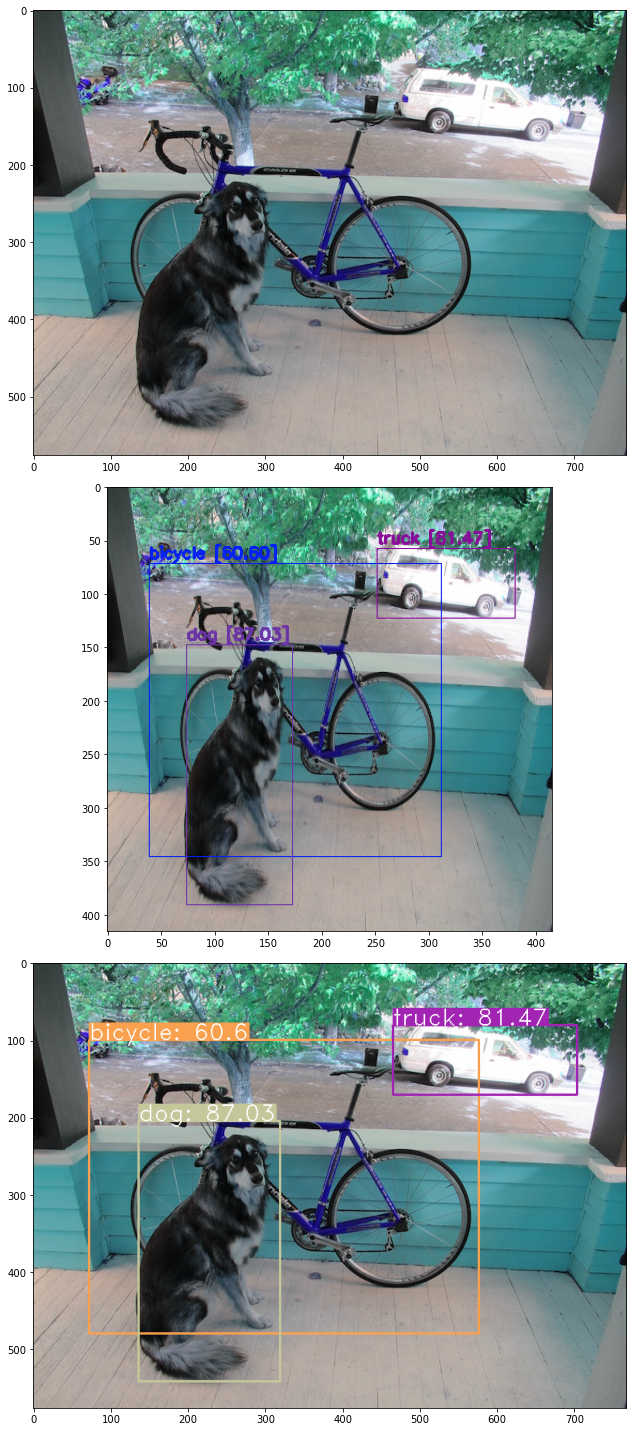

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

axes[0].imshow(image)
axes[1].imshow(image_boxes)

tmp = image.copy()
draw_bboxes(tmp, detections, image_resized)
axes[2].imshow(tmp)

plt.tight_layout()
plt.show()